# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
#import necessary library
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib qt

## Camera calibration

In [2]:

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

## Undistorting image

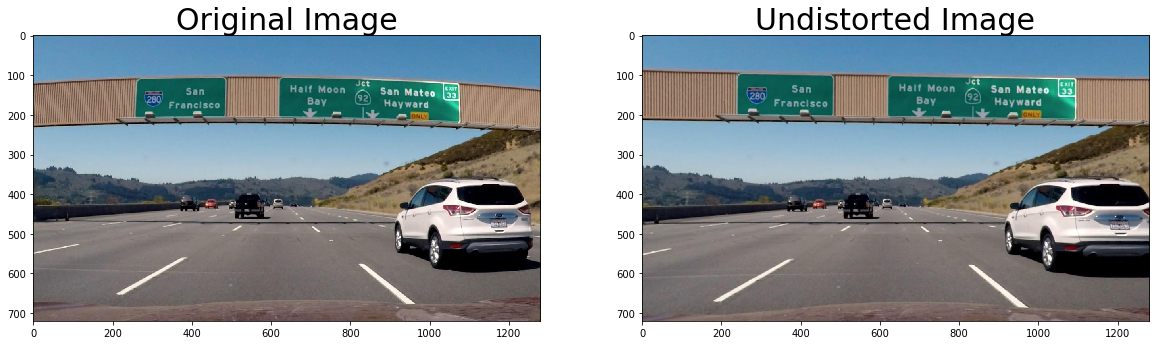

In [3]:
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('examples/signs_vehicles_xygrad.png')

img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('examples/signs_vehicles_xygrad-Copy1.png',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

#Transfer from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Creating binary image

In [4]:
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)*255
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)*255
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.abs(sobelx)
    abs_sobely = np.abs(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary

def hls_select(img, channel = 2, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    C = hls[:,:,channel]*255
    binary = np.zeros_like(C)
    binary[(C > thresh[0]) & (C <= thresh[1])] = 1
    return binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)*255
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.sqrt(np.square(sobelx)+np.square(sobely))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1 
    return binary_output


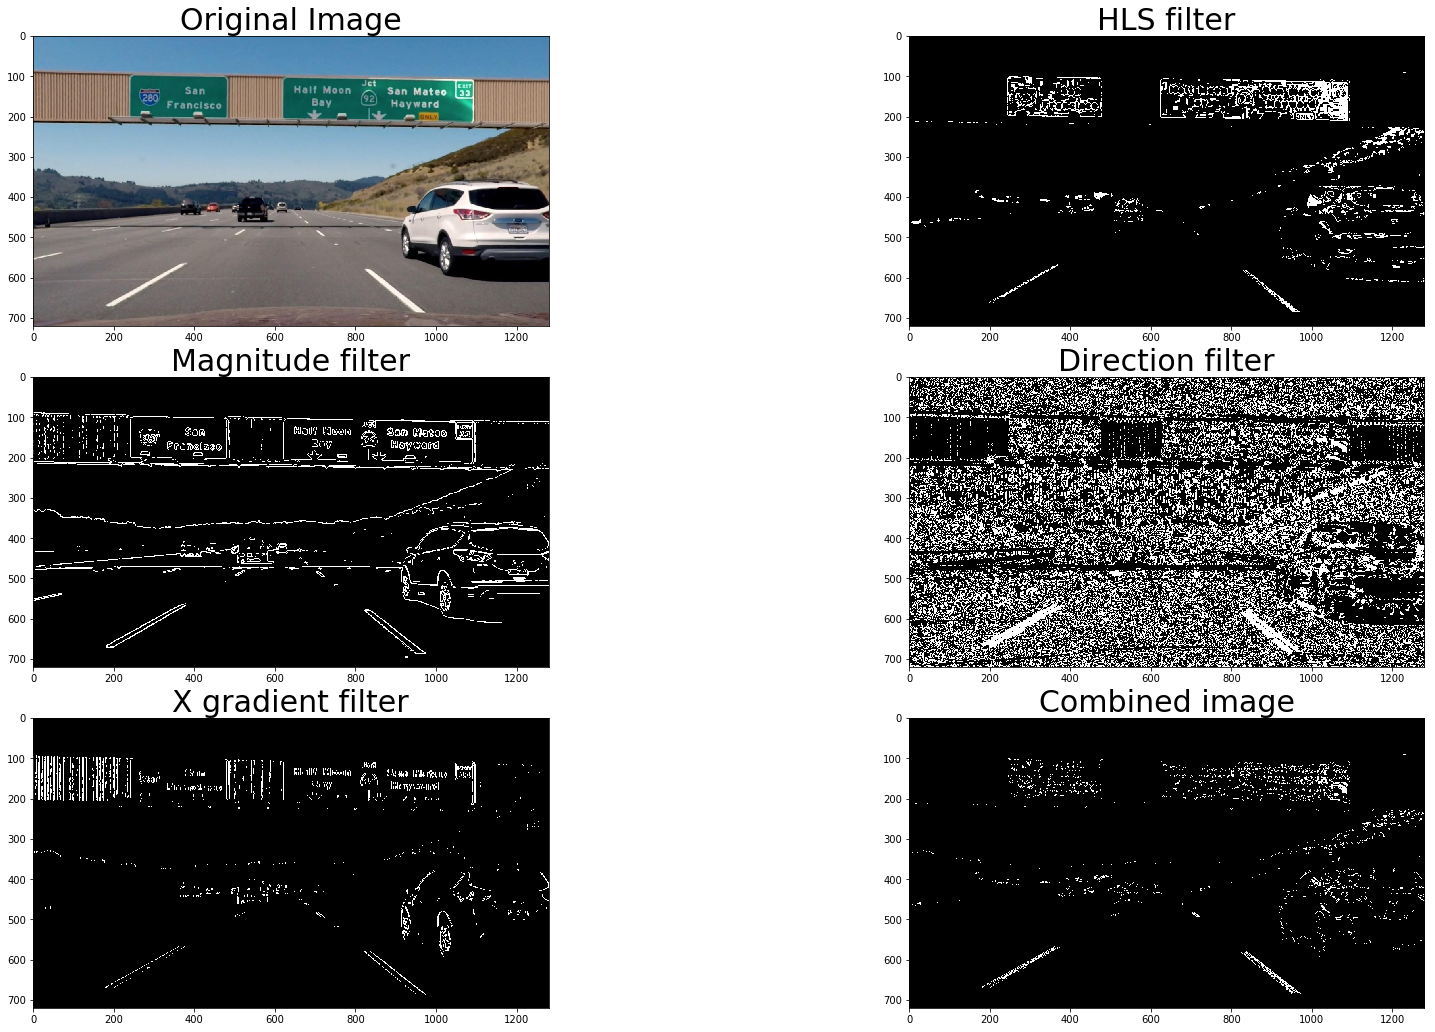

In [5]:
image = mpimg.imread('examples/signs_vehicles_xygrad-Copy1.png')


x_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(50, 150))
y_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(50, 150))
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 150))
hls_binary = hls_select(image, channel = 2, thresh=(120, 200))
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
combined = np.zeros_like(mag_binary)
combined[ ((hls_binary == 1) & (dir_binary==1))|( (mag_binary == 1) & (x_binary==1) & (y_binary ==1))] = 1


# Plot the result
f, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('HLS filter', fontsize=30)

ax3.imshow(mag_binary, cmap='gray')
ax3.set_title('Magnitude filter', fontsize=30)

ax4.imshow(dir_binary, cmap='gray')
ax4.set_title('Direction filter', fontsize=30)

ax5.imshow(x_binary, cmap='gray')
ax5.set_title('X gradient filter', fontsize=30)

ax6.imshow(combined, cmap='gray')
ax6.set_title('Combined image', fontsize=30)

plt.subplots_adjust(left=0., right=None, top=1.5, bottom=0.)

## Transforming a perspective

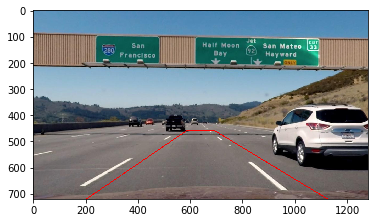

In [6]:
img = cv2.imread('examples/signs_vehicles_xygrad-Copy1.png')
img_size = (img.shape[1],img.shape[0])

src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

#BGR, setting line color red
img = cv2.line(img,(src[0][0],src[0][1]),(src[1][0],src[1][1]),(0,0,255),2)
img = cv2.line(img,(src[1][0],src[1][1]),(src[2][0],src[2][1]),(0,0,255),2)
img = cv2.line(img,(src[2][0],src[2][1]),(src[3][0],src[3][1]),(0,0,255),2)
img = cv2.line(img,(src[3][0],src[3][1]),(src[0][0],src[0][1]),(0,0,255),2)

#BGR to RGB to display by plt
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)


    


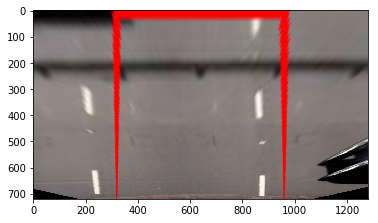

In [7]:
def warp(img, inverse = False):    
    img_size = (img.shape[1],img.shape[0])
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    if inverse == False:
        M = cv2.getPerspectiveTransform(src, dst)
    elif inverse == True:
        M = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

warped = warp(img)
plt.imshow(warped)

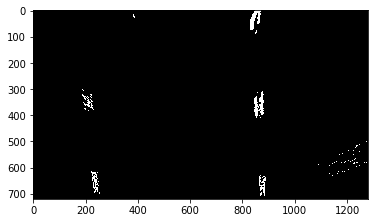

In [8]:
warped = warp(combined)
plt.imshow(warped, cmap = 'gray')

##  Fitting with a polynomial

In [9]:
#Finding peaks in histgram for gredients
def find_peak(histogram):
    first_peak = np.argmax(histogram)
    if (first_peak - 300) >= 0:
        histogram[first_peak-300:first_peak+300] = 0
    else:
        histogram[:first_peak+300] = 0
        histogram[(len(histogram)- first_peak + 300):] = 0
    second_peak = np.argmax(histogram)
    left_peak, right_peak = np.sort([first_peak, second_peak])
    return left_peak, right_peak

#Finding square box, which is likely to include lane pixels
def find_lane(img):
    left_blue = np.zeros_like(img)
    right_red = np.zeros_like(img)
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    first_left, first_right = find_peak(histogram)
    length = img.shape[0]/8
    img_size = (img.shape[1], img.shape[0])
    left_blue = cv2.rectangle(left_blue, (int(first_left-length/2), img_size[1]- 90),
                              (int(first_left+length/2),img_size[1]), 1, -1)
    right_red = cv2.rectangle(right_red, (int(first_right-length/2), img_size[1]- 90),
                              (int(first_right+length/2),img_size[1]), 1, -1)
    
    pre_left, pre_right = first_left, first_right
    
    for i in range(7):
        if i != 6:
            histogram = np.sum(img[img.shape[0]*(8-i-2)/8:img.shape[0]*(8-i-1)/8,:], axis=0)
        else:
            histogram = np.sum(img[0:img.shape[0]*(8-i-1)/8,:], axis=0)
        biggest, second_biggest = find_peak(histogram)
        if ((biggest > (pre_left - length*4/3)) & (biggest < (pre_left + length*4/3))):
            left = biggest
            left_blue = cv2.rectangle(left_blue, (int(left-length/2), img_size[1]- 90*(i+2)),
                          (int(left+length/2),img_size[1]-90*(i+1)), 1, -1)
            pre_left = left
        elif ((second_biggest > (pre_left - length*4/3)) & (second_biggest < (pre_left + length*4/3))):
            left = second_biggest
            left_blue = cv2.rectangle(left_blue, (int(left-length/2), img_size[1]- 90*(i+2)),
                          (int(left+length/2),img_size[1]-90*(i+1)), 1, -1)
            pre_left = left
        if (biggest > (pre_right - length*4/3)) & (biggest < (pre_right + length*4/3)):
            right = biggest
            right_red = cv2.rectangle(right_red, (int(right-length/2), img_size[1]- 90*(i+2)),
                          (int(right+length/2),img_size[1]-90*(i+1)), 1, -1)
            pre_right = right
        elif (second_biggest > (pre_right - length*4/3)) & (second_biggest < (pre_right + length*4/3)):
            right = second_biggest
            right_red = cv2.rectangle(right_red, (int(right-length/2), img_size[1]- 90*(i+2)),
                          (int(right+length/2),img_size[1]-90*(i+1)), 1, -1)
            pre_right = right
    color_binary = np.dstack((right_red, img, left_blue))
    return color_binary, right_red, img, left_blue      
        

##For visualising test image
#Undistortion
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

#Binary transformation
def binary_transform(image):
    x_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(50, 150))
    y_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(50, 150))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50, 150))
    hls_binary = hls_select(image, channel = 2, thresh=(120, 180))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    combined = np.zeros_like(mag_binary)
    combined[ ((hls_binary == 1) & (dir_binary==1))|( (mag_binary == 1) & (x_binary==1) & (y_binary == 1))] = 1
    return combined

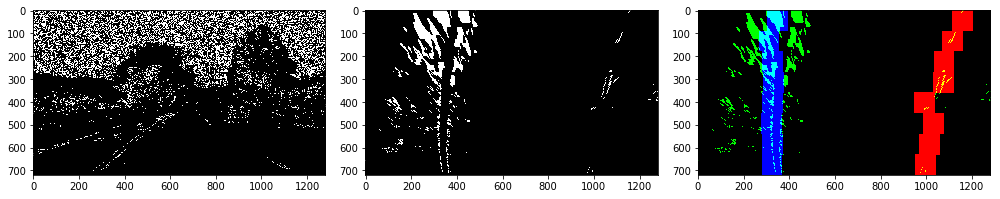

In [11]:
#Visualization, how an image is processed
timg = plt.imread('test_images/test1.jpg')
timg = undistort(timg, mtx, dist)
timg = binary_transform(timg)
fig = plt.figure(figsize=(14,5))
plt.subplot(131)
plt.imshow(timg, cmap = 'gray')
warped_timg = warp(timg)
plt.subplot(132)
plt.imshow(warped_timg, cmap = 'gray')
t_lanes, right, binary, left= find_lane(warped_timg)
plt.subplot(133)
plt.imshow(t_lanes*255)
fig.tight_layout()

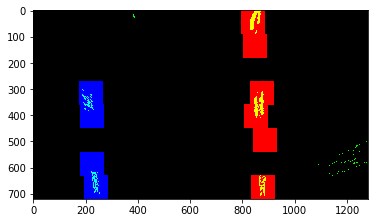

In [12]:
#Visualization, color result 2
lanes, right, binary, left= find_lane(warped)
plt.imshow(lanes*255)

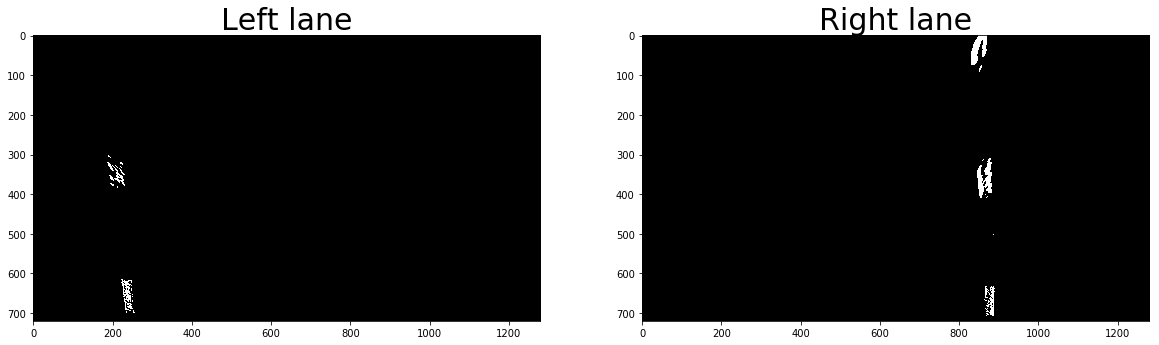

In [14]:
#Visualise each lane pixcels
combined_left = np.zeros_like(binary)
combined_right = np.zeros_like(binary)
combined_left[(binary == 1) & (left == 1)] = 1
combined_right[(binary == 1) & (right == 1)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(combined_left*255, cmap = 'gray')
ax1.set_title('Left lane', fontsize=30)
ax2.imshow(combined_right*255, cmap = 'gray')
ax2.set_title('Right lane', fontsize=30)

In [15]:
#input is 1d binary image
def making_points_list(img):
    height = img.shape[0]
    width = img.shape[1]
    y = []
    x = []
    for i in range(height):
        for j in range(width):
            if img[i][j] == 1:
                y.append(i)
                x.append(j)
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

#measuring curvanture
def measuring_curv(l_x, l_y, r_x, r_y):
    l_max = 720
    r_max = 720
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    left_fit_cr = np.polyfit(l_y*ym_per_pix, l_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(r_y*ym_per_pix, r_x*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*l_max + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*r_max + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    average_curv = (left_curverad + right_curverad)/2
    return average_curv

#adding necessary infomation on an image
def get_text_info(img, l_x, l_y, r_x, r_y, l_lane_pix, r_lane_pix):
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    screen_middel_pixel = img.shape[1]/2
    car_middle_pixel = int((r_lane_pix + l_lane_pix)/2)
    screen_off_center = screen_middel_pixel-car_middle_pixel
    meters_off_center = round(xm_per_pix * screen_off_center, 2)
    curv_in_meters = int(measuring_curv(l_x, l_y, r_x, r_y))
    return meters_off_center, curv_in_meters
    

#calculating polyfit and r squared
#These codes are coming from 
#`http://stackoverflow.com/questions/893657/how-do-i-calculate-r-squared-using-python-and-numpy`
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                         # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results['determination'] = round(ssreg / sstot, 3)

    return results

3147


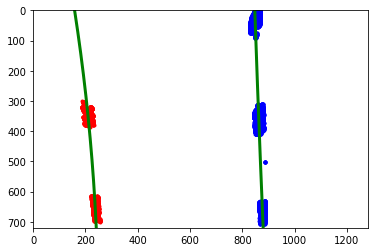

In [19]:
left_x, left_y = making_points_list(combined_left)
right_x, right_y = making_points_list(combined_right)

l_results = polyfit(left_y, left_x, 2)
left_fit = l_results['polynomial']
ly_vals = np.linspace(0, 100, num=len(left_x))*7.2
left_fitx = left_fit[0]*ly_vals**2 + left_fit[1]*ly_vals + left_fit[2]


r_results = polyfit(right_y, right_x, 2)
right_fit = r_results['polynomial']
ry_vals = np.linspace(0, 100, num=len(right_x))*7.2
right_fitx = right_fit[0]*ry_vals**2 + right_fit[1]*ry_vals + right_fit[2]


# avg_curverad, left_curverad, right_curverad = measuring_curv(left_fitx, ly_vals, right_fitx, ry_vals)
# avg_curverad = measuring_curv(left_x, ly_vals, right_x, ry_vals)
off_center, avg_curverad = get_text_info(img, left_x, ly_vals, right_x, ry_vals, left_fitx[-1], right_fitx[-1])

print(avg_curverad)
# print(left_curverad, 'm', right_curverad, 'm')
plt.plot(left_x, left_y, '.', color='red')
plt.plot(right_x, right_y, '.', color='blue')
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ly_vals, color='green', linewidth=3)
plt.plot(right_fitx, ry_vals, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

## Result

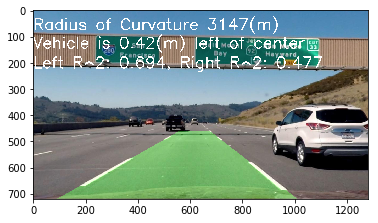

In [20]:
undist = cv2.imread('examples/signs_vehicles_xygrad-Copy1.png')

warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ly_vals]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ry_vals])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
# newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
newwarp = warp(color_warp, inverse = True)
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
off_center, avg_curved = get_text_info(result, left_x, ly_vals, right_x, ry_vals, left_fitx[-1], right_fitx[-1])

font = cv2.FONT_HERSHEY_SIMPLEX
# font = cv2.FONT_HERSHEY_PLAIN
# font = cv2.FONT_HERSHEY_SCRIPT_SIMPLEX
# font = cv2.FONT_HERSHEY_COMPLEX
result = cv2.putText(result,'Radius of Curvature %d(m)' %avg_curverad,(0,75), font, 2,(255,255,255),4)
result = cv2.putText(result,'Vehicle is {}(m) left of center'.format(off_center) ,(0,145), 
                     font, 2,(255,255,255),4)
result = cv2.putText(result,'Left R^2: {}, Right R^2: {}'.format(l_results['determination'], 
                                r_results['determination']),(0,220), font, 2,(255,255,255),4)


# plt.text(0, 50, off_center, fontsize=15, color = 'white')
# plt.text(0, 50, 'Radius of Curvature %d(m)' %avg_curverad, fontsize=15, color = 'white')
# plt.text(0, 120, 'Vehicle is {}(m) left of center'.format(off_center), fontsize=15, color = 'white')
plt.imshow(result)

## Testing image

In [21]:
#functions, which are used for pipeline

#Camera calibration & undistortion
def calib_undist(original_img):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    img_size = (original_img.shape[1], original_img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(original_img, mtx, dist, None, mtx)
    return dst

#Undistortion
def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

#Binary transformation
def binary_transform(image):
    x_binary = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(50, 150))
    y_binary = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(30, 150))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(40, 150))
    hls_binary = hls_select(image, channel = 2, thresh=(110, 180))
    dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
    combined = np.zeros_like(mag_binary)
    combined[ ((hls_binary == 1) & (dir_binary==1))|( (mag_binary == 1) & (x_binary==1) & (y_binary == 1))] = 1
    return combined

#Pespective transformation
#--> Using warp(img) function

#Drawing line
def drawing(img, binary):
    warped_binary = warp(binary)
    lanes, right, binary, left= find_lane(warped_binary)
    
    #making points for both sides
    combined_left = np.zeros_like(binary)
    combined_right = np.zeros_like(binary)
    combined_left[(binary == 1) & (left == 1)] = 1
    combined_right[(binary == 1) & (right == 1)] = 1
    left_x, left_y = making_points_list(combined_left)
    right_x, right_y = making_points_list(combined_right)
    
    #Fitting with polynomials
    l_results = polyfit(left_y, left_x, 2)
    left_fit = l_results['polynomial']
    ly_vals = np.linspace(0, 100, num=len(left_x))*7.2
    left_fitx = left_fit[0]*ly_vals**2 + left_fit[1]*ly_vals + left_fit[2]
    r_results = polyfit(right_y, right_x, 2)
    right_fit = r_results['polynomial']
    ry_vals = np.linspace(0, 100, num=len(right_x))*7.2
    right_fitx = right_fit[0]*ry_vals**2 + right_fit[1]*ry_vals + right_fit[2]
    
    #preparing color pre-warp image 
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    #Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ly_vals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ry_vals])))])
    pts = np.hstack((pts_left, pts_right))

    #Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    #Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = warp(color_warp, inverse = True)
    
    #Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    #Get necessary text info
    off_center, avg_curverad = get_text_info(result, left_x, ly_vals, right_x, ry_vals, 
                                             left_fitx[-1], right_fitx[-1])

    font = cv2.FONT_HERSHEY_SIMPLEX
    result = cv2.putText(result,'Radius of Curvature %d(m)' %avg_curverad,(0,75), font, 2,(255,255,255),4)
    result = cv2.putText(result,'Vehicle is {}(m) left of center'.format(off_center) ,(0,145), 
                 font, 2,(255,255,255),4)
    result = cv2.putText(result,'Left R^2: {}, Right R^2: {}'.format(l_results['determination'], 
                                r_results['determination']),(0,220), font, 2,(255,255,255),4)
    return result

In [22]:
#for testing, not included in pipeline
def drawing_from_bird(binary):
    warped_binary = warp(binary)
    lanes, right, binary, left= find_lane(warped_binary)
    
    #making points for bith sides
    combined_left = np.zeros_like(binary)
    combined_right = np.zeros_like(binary)
    combined_left[(binary == 1) & (left == 1)] = 1
    combined_right[(binary == 1) & (right == 1)] = 1
    left_x, left_y = making_points_list(combined_left)
    right_x, right_y = making_points_list(combined_right)
    
    #fitting left lane
    left_fit = np.polyfit(left_y, left_x, 2)
    ly_vals = np.linspace(0, 100, num=len(left_x))*7.2
    left_fitx = left_fit[0]*ly_vals**2 + left_fit[1]*ly_vals + left_fit[2]
    #fitting right lane
    right_fit = np.polyfit(right_y, right_x, 2)
    ry_vals = np.linspace(0, 100, num=len(right_x))*7.2
    right_fitx = right_fit[0]*ry_vals**2 + right_fit[1]*ry_vals + right_fit[2]
    return ly_vals, left_fitx, ry_vals, right_fitx

In [23]:
def pipeline(img, mtx, dist):
    image = undistort(img, mtx, dist)
    combined_binary = binary_transform(image)
    result = drawing(image, combined_binary)
    return result

def pipeline_for_test(img):
    image = calib_undist(img)
    combined_binary = binary_transform(image)
    result = drawing(image, combined_binary)
    return result

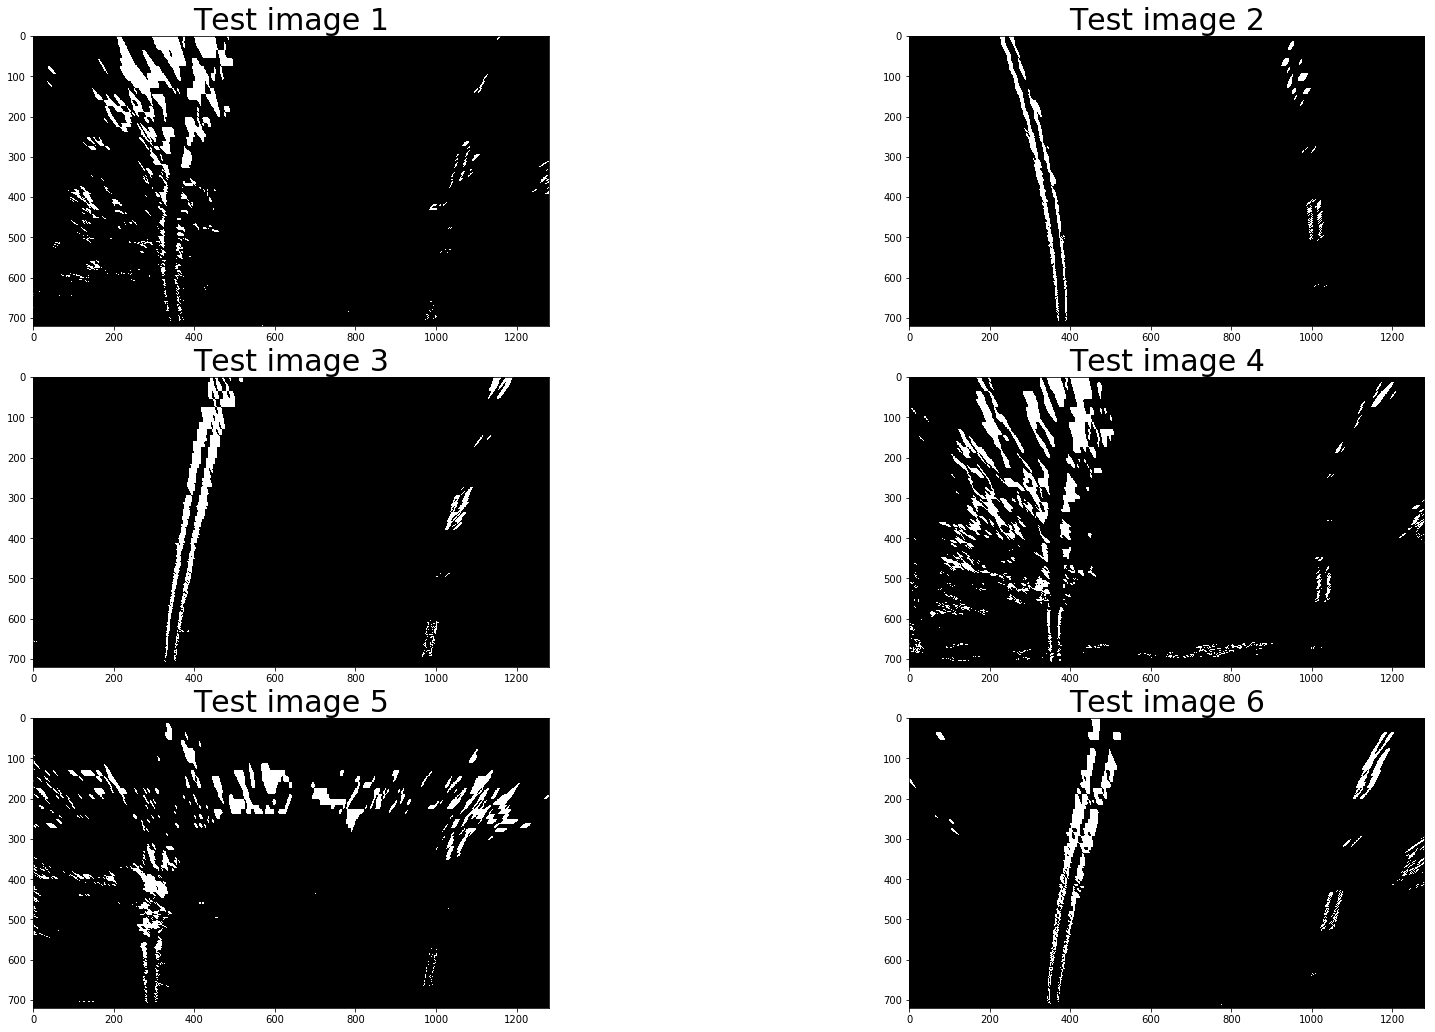

In [24]:
#Visualising test images from bird's eye
test_images = np.sort(glob.glob('test_images/test*.jpg'))
# f, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 9))
f, Ax = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
plt.subplots_adjust(left=0., right=None, top=1.5, bottom=0.)

for i in range(len(test_images)):
    t_img = mpimg.imread(test_images[i])
    idx = Ax[int(i/2)][int((i+2)%2)]
    bi_pic = binary_transform(t_img)
    warped = warp(bi_pic)
    idx.imshow(warped, cmap = 'gray')
    idx.set_title("Test image %d" %(i+1) , fontsize=30)

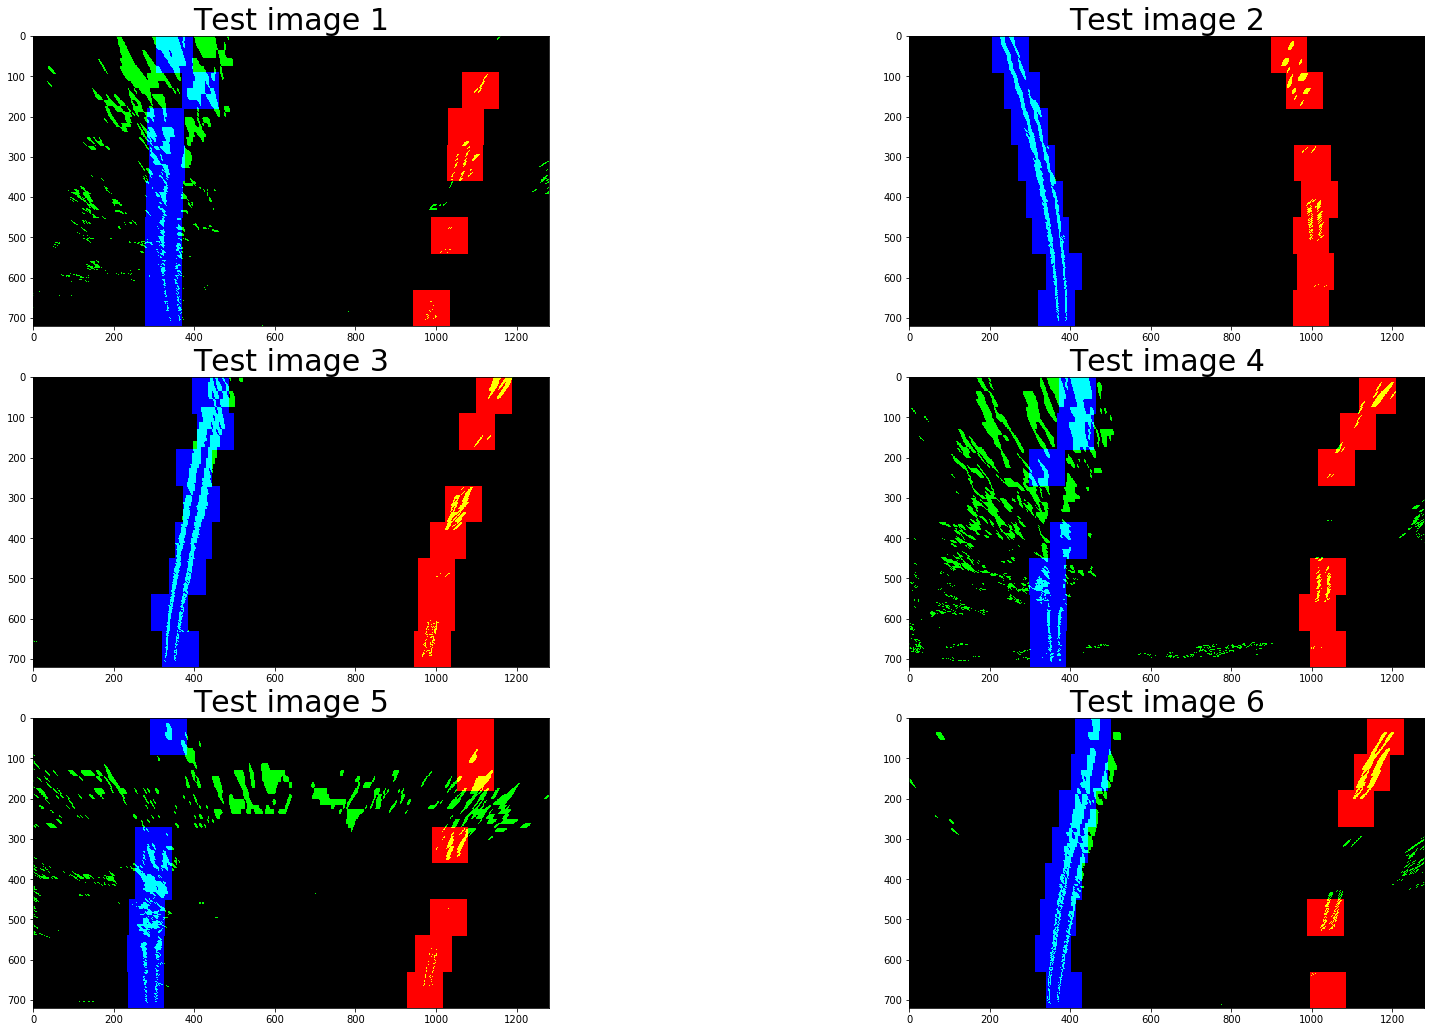

In [25]:
#Visualising test images fitting with a polynomials
test_images = np.sort(glob.glob('test_images/test*.jpg'))
# f, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 9))
f, Ax = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
plt.subplots_adjust(left=0., right=None, top=1.5, bottom=0.)

for i in range(len(test_images)):
    t_img = mpimg.imread(test_images[i])
    idx = Ax[int(i/2)][int((i+2)%2)]
    bi_pic = binary_transform(t_img)
    warped = warp(bi_pic)
    lanes, right, binary, left= find_lane(warped)
    idx.imshow(lanes*255)
    idx.set_title("Test image %d" %(i+1) , fontsize=30)

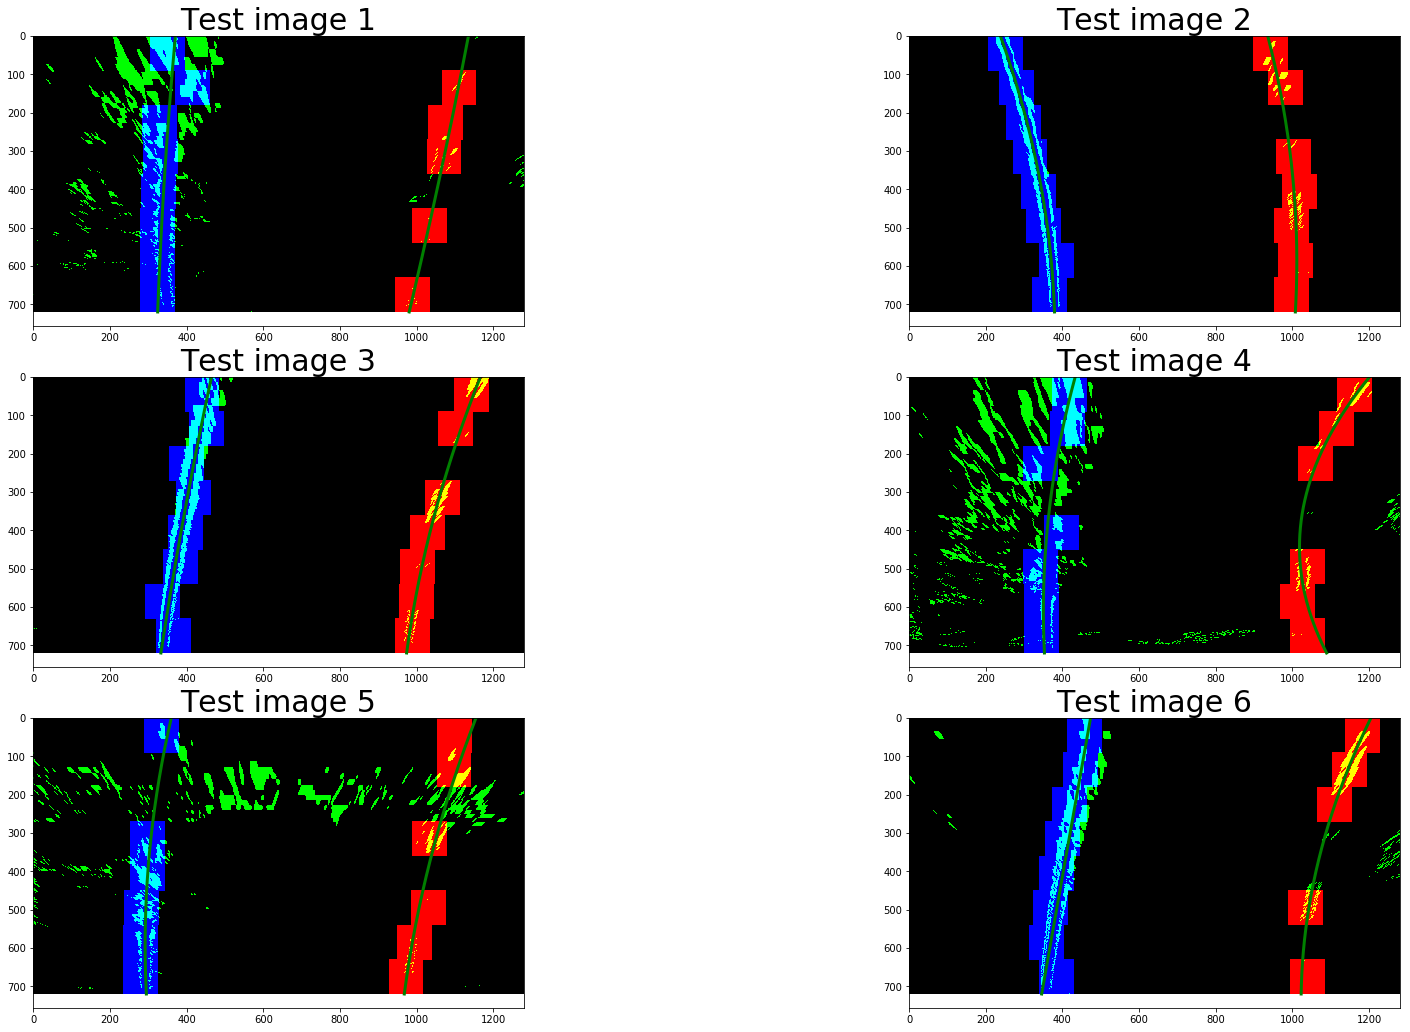

In [26]:
#Visualising test images fitting with a polynomials
test_images = np.sort(glob.glob('test_images/test*.jpg'))
# f, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 9))
f, Ax = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
plt.subplots_adjust(left=0., right=None, top=1.5, bottom=0.)

for i in range(len(test_images)):
    t_img = mpimg.imread(test_images[i])
    idx = Ax[int(i/2)][int((i+2)%2)]
    bi_pic = binary_transform(t_img)
    ly_vals, left_fitx, ry_vals, right_fitx = drawing_from_bird(bi_pic)
    warped = warp(bi_pic)
    lanes, right, binary, left= find_lane(warped)
    idx.imshow(lanes*255)
    idx.plot(left_fitx, ly_vals, color='green', linewidth=3)
    idx.plot(right_fitx, ry_vals, color='green', linewidth=3)
    idx.set_title("Test image %d" %(i+1) , fontsize=30)

In [ ]:
#Writing test examples in './output_images/'
test_images = np.sort(glob.glob('test_images/test*.jpg'))
# f, ((ax1, ax2),( ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(24, 9))
f, Ax = plt.subplots(3, 2, figsize=(24, 9))
f.tight_layout()
plt.subplots_adjust(left=0., right=None, top=1.5, bottom=0.)

for i in range(len(test_images)):
    image = mpimg.imread(test_images[i])
    image = pipeline(image, mtx, dist)
    Ax[int(i/2)][int((i+2)%2)].imshow(image)
    Ax[int(i/2)][int((i+2)%2)].set_title("Test image %d" %(i+1) , fontsize=30)
    cv2.imwrite('output_images/test%d.jpg' %(i+1),image)
    

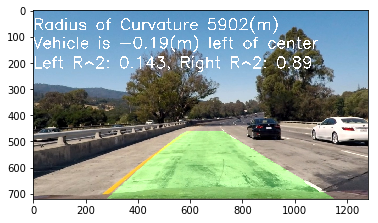

In [27]:
#Showing one of the test picture 
plt.imshow(pipeline_for_test(mpimg.imread('test_images/test1.jpg')))

In [ ]:
#Creating video 
test1_output = 'test1.mp4'
clip1 = VideoFileClip("project_video.mp4")
test1_clip = clip1.fl_image(pipeline_for_test) #NOTE: this function expects color images!!
%time test1_clip.write_videofile(test1_output, audio=False)

In [ ]:
#Playing video here
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test1_output))